In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs
import torch
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

from src.utils import find_ckpt_file, convert_to_tensor
import h5py
import random
from src.evals.eval_trees import EvalCntrees

In [2]:
corr = 0.25

# Load Model

In [ ]:
model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "tree_maze")
#model_name, path_to_pkl, eval_dset_path = configs.get_model_paths(corr, "tree_maze_bigger_models", 'layer4')


epoch=35-val_loss=0.000347.ckpt


In [4]:
# Extract parameters using regex
import re

n_embd = int(re.search(r'embd(\d+)', model_name).group(1))
n_layer = int(re.search(r'layer(\d+)', model_name).group(1))
n_head = int(re.search(r'head(\d+)', model_name).group(1))
dropout = float(re.search(r'drop(\d*\.?\d*)', model_name).group(1))

# Extract correlation and state_dim from eval dataset path
state_dim = int(re.search(r'state_dim(\d+)', eval_dset_path).group(1))

model_config = {
    "n_embd": n_embd,
    "n_layer": n_layer,
    "n_head": n_head,
    "state_dim": 10,
    "action_dim": 4,
    "dropout": dropout,
    "test": True,
    "name": "transformer_end_query",
    "optimizer_config": None,
}

In [5]:
from src.models.transformer_end_query import Transformer
model_config['initialization_seed'] = 0
model = Transformer(**model_config)
checkpoint = torch.load(path_to_pkl)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
model = model.to('cuda')


/tmp/ipykernel_4082122/443524507.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_pkl)


# Load Dataset and Create Environment

In [6]:
n_eval_envs = -1 #50
traj_horizon = 800

is_h5_file = eval_dset_path.endswith('.h5')
if is_h5_file:
    eval_trajs = h5py.File(eval_dset_path, 'r')
    traj_indices = list(eval_trajs.keys())
    n_eval_envs = min(n_eval_envs, len(traj_indices))
    random.seed(0)
    traj_indices = random.sample(traj_indices, n_eval_envs)
    random.seed()
    if n_eval_envs != -1:
        eval_trajs = [eval_trajs[i] for i in traj_indices]
    else:
        n_eval_envs = len(traj_indices)
else:  # Pickle file
    with open(eval_dset_path, 'rb') as f:
        eval_trajs = pickle.load(f)
    n_eval_envs = min(n_eval_envs, len(eval_trajs))
    if n_eval_envs != -1:
        random.seed(0)
        eval_trajs = random.sample(eval_trajs, n_eval_envs)
        random.seed()
    else:
        n_eval_envs = len(eval_trajs)


# Run Model

In [7]:
query_type = 'root'

In [8]:
i_eval = 7

In [10]:
results = {l: {
    'states': [],
    'next_states': [],
    'delta_xc_losses': []
} for l in range(model.n_layer)}

env_acc = []
baseline_env_acc = []
traj = eval_trajs[i_eval]
if traj['context_rewards'][:traj_horizon].sum().item() == 0:
    raise ValueError('No rewards in context')
env_config = {
    'max_layers': 7,
    'horizon': 1600,
    'branching_prob': 1.0,
    'node_encoding_corr': corr,
    'state_dim': 10,
    'initialization_seed': np.array(traj['initialization_seed']).item()
}
env = EvalCntrees().create_env(env_config, np.array(traj['goal']), i_eval)
optimal_action_map, dist_from_goal = env.make_opt_action_dict()

# Choose query state
if query_type == 'root':
    valid_query_states = [np.array(env.root.encoding())]
elif query_type in ['far', 'middle']:
    valid_query_states = []
    for i in range(len(traj['context_states'])):
        if traj['context_states'][i].tolist() == list(env.root.encoding()):
            continue
        d = dist_from_goal[tuple(traj['context_states'][i].tolist())]
        if query_type == 'far' and d < 12:
            continue
        elif query_type == 'middle' and d != 6:
           continue
        valid_query_states.append(traj['context_states'][i])
if len(valid_query_states) == 0:
    raise ValueError('No valid query states found')
else:
    query_state = valid_query_states[np.random.choice(len(valid_query_states))]

# Prepare batch and optimal action information
batch = {
    'context_states': np.array(traj['context_states'][:traj_horizon]),
    'context_actions': np.array(traj['context_actions'][:traj_horizon]),
    'context_next_states': np.array(traj['context_next_states'][:traj_horizon]),
    'context_rewards': np.array(traj['context_rewards'][:traj_horizon])[:, None],
    'query_states': np.array(query_state),
    }
batch['zeros'] = torch.zeros(10 ** 2 + 4 + 1).float()
for k in batch.keys():
    batch[k] = convert_to_tensor([batch[k]]).to(model.device)
optimal_action = optimal_action_map[tuple(query_state.tolist())]
optimal_action_tensor = torch.zeros(4).to(model.device)
optimal_action_tensor[optimal_action] = 1

# Get baseline loss
with torch.no_grad():
    out = model(batch).squeeze()
first_reward_idx = np.argwhere(traj['context_rewards'][:traj_horizon] == 1)[0,0]
baseline_xc_loss = torch.nn.functional.cross_entropy(out, optimal_action_tensor).item()

processed_transitions = set()
for i in range(traj_horizon):
    s = traj['context_states'][i]
    s_next = traj['context_next_states'][i]
    transition = frozenset([tuple(s), tuple(s_next)])
    if transition in processed_transitions:
        continue
    processed_transitions.add(transition)
    state = env.node_map[tuple(s.tolist())]
    next_state = env.node_map[tuple(s_next.tolist())]
    
    # Find all indices where either s or s_next appears
    s_indices = []
    for j in range(traj_horizon):
        if np.array_equal(s, traj['context_states'][j]) and np.array_equal(s_next, traj['context_next_states'][j]):
            s_indices.append(j)
        if np.array_equal(s_next, traj['context_states'][j]) or np.array_equal(s_next, traj['context_next_states'][j]):
            s_indices.append(j)
    
    s_indices = torch.tensor(list(set(s_indices)))  # Remove duplicates
    s_indices_mask = torch.zeros(traj_horizon+1).bool()
    s_indices_mask[s_indices[0]] = True
    state_mask = torch.ones((traj_horizon+1, traj_horizon+1))  # Create a mask for the state
    state_mask[:-1, s_indices_mask] = 0
    state_mask = torch.tril(state_mask)
    state_mask = state_mask.bool().to(model.device)

    for b in model.transformer.h:
        b._additional_attention_mask = None

    for l in range(model.n_layer):  # Apply the mask to each layer
        model.transformer.h[l]._additional_attention_mask = state_mask
        with torch.no_grad():
            out = model(batch).squeeze()
        intervened_xc_loss = torch.nn.functional.cross_entropy(out, optimal_action_tensor).item()
        results[l]['delta_xc_losses'].append(baseline_xc_loss - intervened_xc_loss)
        results[l]['states'].append([state.layer, state.pos])
        results[l]['next_states'].append([next_state.layer, next_state.pos])
        model.transformer.h[l]._additional_attention_mask = None

# Plot

In [11]:
from copy import copy
import networkx as nx

def plot_trajectory(
        states, next_states, query_state, attentions, env):
    
    G = env.to_networkx()
    pos = nx.kamada_kawai_layout(G)

    fig, ax = plt.subplots(figsize=(4,4))  # Create a new figure
    nx.draw(G, pos,
           node_color='lightblue',
           edge_color='white',
           node_size=100,
           font_size=8,
           font_weight='bold',
           width=1,
           alpha=1.)


    goal_node = env.node_map[tuple(env.goal.tolist())]
    goal_state = (goal_node.layer, goal_node.pos)
    query_node = env.node_map[tuple(query_state.tolist())]
    query_state = (query_node.layer, query_node.pos)
    # Then draw specific nodes in green
    nx.draw_networkx_nodes(G, pos,
                      nodelist=[query_state],
                      node_color='green',
                      node_size=100)
    nx.draw_networkx_nodes(G, pos,
                      nodelist=[goal_state],
                      node_color='green',
                      node_size=100,
                      node_shape='*')
    
    for state, next_state, attention in zip(states, next_states, attentions):
        edge_color = 'red' if attention > 0 else 'blue'
        nx.draw_networkx_edges(G, pos,
            edgelist=[(tuple(state), tuple(next_state))],
            edge_color=edge_color,
            alpha=abs(attention),
            width=2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

0.9674044568091631


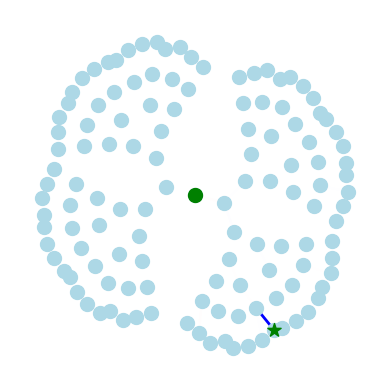

1.7971584517508745


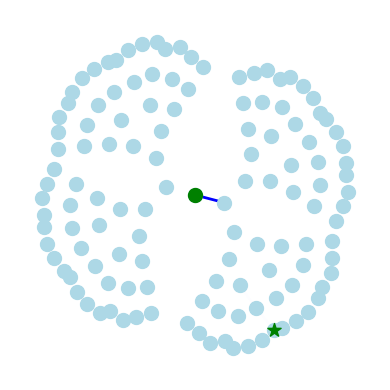

0.0


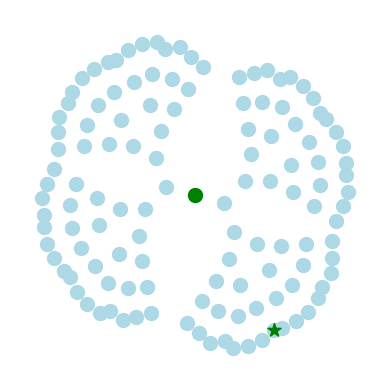

In [11]:
for layer in range(model.n_layer):
    states = results[layer]['states']
    next_states = results[layer]['next_states']
    delta_xc_losses = results[layer]['delta_xc_losses']
    max_val = np.max(np.abs(delta_xc_losses))
    print(max_val)
    _delta_xc_losses = np.array(delta_xc_losses)
    if max_val > 0:
        _delta_xc_losses = _delta_xc_losses/max_val
    plot_trajectory(states, next_states, query_state, _delta_xc_losses, env)